Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Normalization
from glob import glob


In [5]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## 1. Data Reading/Data Understanding

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

## 2. Dataset creation

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [15]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [17]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell', 'vascular lesion']


## 3. Dataset visualisation

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [20]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12,10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Model Building & training

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [26]:
### Your code goes here
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

C:\Users\Windows\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [28]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [31]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.2092 - loss: 2.1474 - val_accuracy: 0.3311 - val_loss: 1.8406
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 301ms/step - accuracy: 0.3700 - loss: 1.8043 - val_accuracy: 0.4497 - val_loss: 1.6176
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - accuracy: 0.4262 - loss: 1.6206 - val_accuracy: 0.5101 - val_loss: 1.4647
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.5051 - loss: 1.4096 - val_accuracy: 0.5280 - val_loss: 1.4161
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 297ms/step - accuracy: 0.5260 - loss: 1.2965 - val_accuracy: 0.5257 - val_loss: 1.4092
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 317ms/step - accuracy: 0.5771 - loss: 1.2172 - val_accuracy: 0.5235 - val_loss: 1.3888
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 298ms/step - accuracy: 0.5583 - loss: 1.2241 - val_accuracy: 0.5235 - val_loss: 1.4114
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.5999 - loss: 1.1511 - val_accu

### Visualizing training results

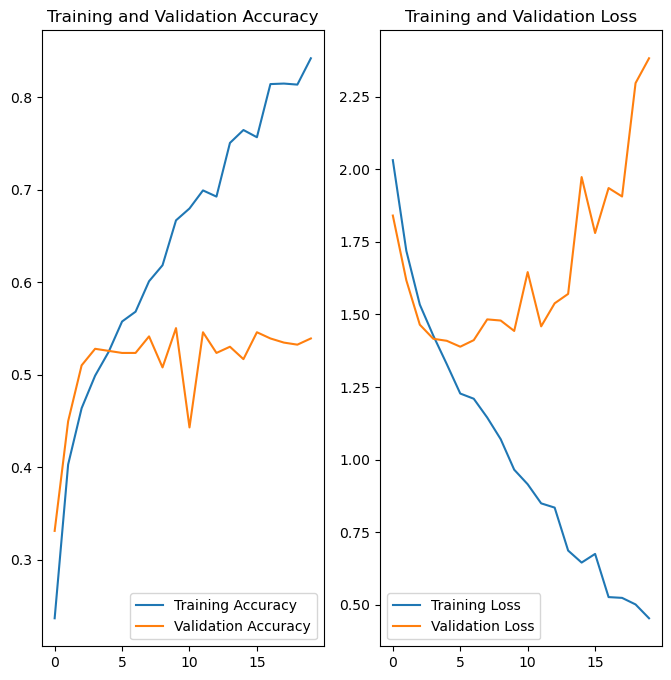

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Findings:

As we can see that now the Training and Validation accuracy are not in the same level and the highest accuracy achieved is around 90% in training whereas 50-52% in validation. This shows the overfiting Need to use data augmentation which can improve the model performance
 <b>Data Augmentation and Dropout</b> to handle the overfitting issue of the model

### 5. Data augmentation

In [37]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [38]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [39]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

In [40]:
### Train the model

The Training and Validation accuracy are now nearly at the same level, with the highest accuracy achieved being around 60%. This highlights the positive impact of Data Augmentation on improving the model's performance. However, there is still room to further enhance the model's accuracy.

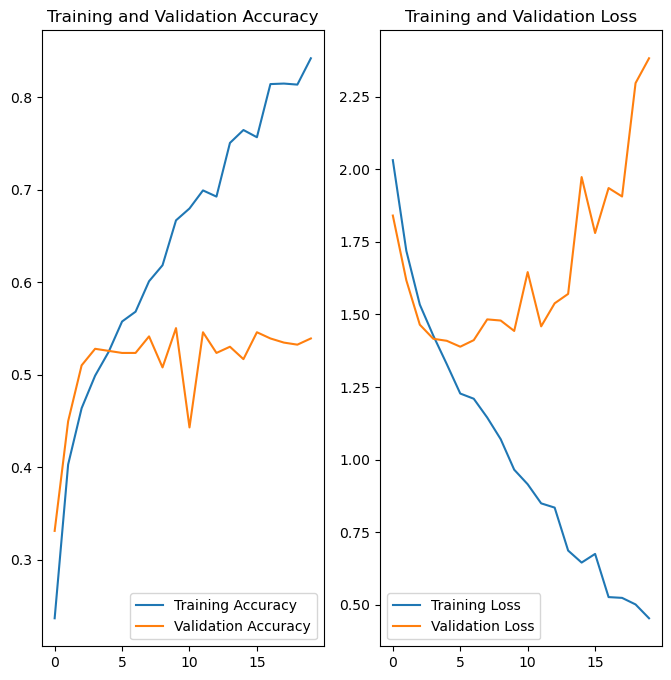

In [42]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

### 6. Model Building & training:
### Create the model, compile and train the model


In [44]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [45]:
### Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
## Your code goes here


### Training the model

In [48]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 462ms/step - accuracy: 0.2257 - loss: 2.0453 - val_accuracy: 0.4228 - val_loss: 1.6914
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 416ms/step - accuracy: 0.4210 - loss: 1.6551 - val_accuracy: 0.5011 - val_loss: 1.4742
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 476ms/step - accuracy: 0.4864 - loss: 1.4600 - val_accuracy: 0.5145 - val_loss: 1.5290
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step - accuracy: 0.5081 - loss: 1.4425 - val_accuracy: 0.4340 - val_loss: 1.6603
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 554ms/step - accuracy: 0.4938 - loss: 1.4297 - val_accuracy: 0.5235 - val_loss: 1.3879
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 569ms/step - accuracy: 0.5240 - loss: 1.3496 - val_accuracy: 0.4787 - val_loss: 1.5124
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 559ms/step - accuracy: 0.5045 - loss: 1.3788 - val_accuracy: 0.5213 - val_loss: 1.4154
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 565ms/step - accuracy: 0.5271 - loss: 1.2880 - val_accu

### Visualizing the results

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [53]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

Path              Label
0     CNN\Skin cancer ISIC The International Skin Im...  actinic keratosis
1     CNN\Skin cancer ISIC The International Skin Im...  actinic keratosis
2     CNN\Skin cancer ISIC The International Skin Im...  actinic keratosis
3     CNN\Skin cancer ISIC The International Skin Im...  actinic keratosis
4     CNN\Skin cancer ISIC The International Skin Im...  actinic keratosis
...                                                 ...                ...
2234  CNN\Skin cancer ISIC The International Skin Im...    vascular lesion
2235  CNN\Skin cancer ISIC The International Skin Im...    vascular lesion
2236  CNN\Skin cancer ISIC The International Skin Im...    vascular lesion
2237  CNN\Skin cancer ISIC The International Skin Im...    vascular lesion
2238  CNN\Skin cancer ISIC The International Skin Im...    vascular lesion

[2239 rows x 2 columns]

### 7.Class distribution

Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


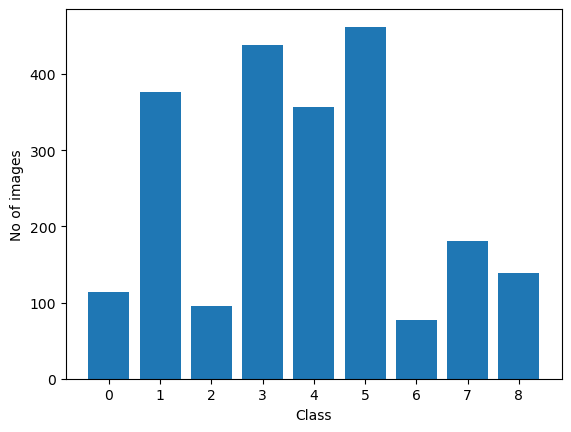

In [55]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
From the chart we can conclude that the class with <b>label 6 </b>has the <b>least number</b> of samples
#### - Which classes dominate the data in terms proportionate number of samples?
From the chart we can conclude that the class with <b>label 5 </b>has the <b>dominate</b> data in terms proporionate number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

### 8.Handling class imbalances

In [59]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [62]:
import pathlib
import Augmentor

# Define the base path to the training dataset
path_to_training_dataset = pathlib.Path("CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

# Example class names
#class_names = ["pigmented benign keratosis"]

# Augment images for each class
for i in class_names:
    class_path = path_to_training_dataset / i  # Path to each class
    
    # Check if the directory exists and contains images
    if not class_path.exists():
        print(f"Error: Directory {class_path} does not exist.")
        continue

    # Check if the directory contains supported image files
    image_files = list(class_path.glob("*.jpg")) + list(class_path.glob("*.jpeg")) + list(class_path.glob("*.png"))
    #print(image_files)
    if not image_files:
        print(f"Error: No supported image files found in {class_path}.")
        continue
    # Initialize Augmentor pipeline
    print(str(class_path))
    p = Augmentor.Pipeline(str(class_path))
    
    # Define augmentations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    
    # Add samples
    p.sample(500)  # Ensure sufficient augmented images 

CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis
Initialised with 114 image(s) found.
Output directory set to CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x199E238BAD0>: 100%|█| 500/500 [00:08<00:


CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19A3E349310>: 100%|█| 500/500 [00:08<00:00, 55.66 Samples/


CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma
Initialised with 95 image(s) found.
Output directory set to CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x199E23FFF10>: 100%|█| 500/500 [00:09<00:00, 54.74 Samples/


CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma
Initialised with 438 image(s) found.
Output directory set to CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x19A40A56AD0>: 100%|█| 500/500 [00:51<00


CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus
Initialised with 357 image(s) found.
Output directory set to CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1022x767 at 0x19A3E5AA450>: 100%|█| 500/500 [00:39<00:00, 12.52 Samples


CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19A3E447F10>: 100%|█| 500/500 [00:08<00:00, 56.15 Samples/


CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x199E2388E90>: 100%|█| 500/500 [00:20<00:00, 24.58 Samples


CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell
Initialised with 181 image(s) found.
Output directory set to CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19A3E3490D0>: 100%|█| 500/500 [00:07<00:00, 68.90 Samples/


CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion
Initialised with 139 image(s) found.
Output directory set to CNN\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19A3E0C7F10>: 100%|█| 500/500 [00:07<00:00, 63.54 Samples/


In [63]:
output_dir = pathlib.Path('CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [65]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['CNN\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_5e44783b-99f5-45c4-ba5b-d015b8a36d11.jpg',
 'CNN\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_058bc833-72f9-45f7-8acd-58dc4752d521.jpg',
 'CNN\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_523e6afd-ed97-4639-9300-5caf55139256.jpg',
 'CNN\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_a8c094d5-adbc-4d39-a17e-3ec59a6eb93e.jpg',
 'CNN\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_21360433-0994-44b1-95e7-9d68c7db1996.jpg',
 'CNN\\Skin cancer ISIC The International Ski

In [66]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [67]:
path_list_new = [x for x in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
path_list_new[:5]

['CNN\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_5e44783b-99f5-45c4-ba5b-d015b8a36d11.jpg',
 'CNN\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_058bc833-72f9-45f7-8acd-58dc4752d521.jpg',
 'CNN\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_523e6afd-ed97-4639-9300-5caf55139256.jpg',
 'CNN\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_a8c094d5-adbc-4d39-a17e-3ec59a6eb93e.jpg',
 'CNN\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_21360433-0994-44b1-95e7-9d68c7db1996.jpg']

In [68]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [69]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df._append(df2)

In [70]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell                 681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### 9.Model Building & training

#### **Todo**: Train the model on the data created using Augmentor

In [74]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [76]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [78]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [80]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

C:\Users\Windows\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [82]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [84]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 91s 490ms/step - accuracy: 0.2022 - loss: 2.0961 - val_accuracy: 0.4217 - val_loss: 1.5014
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 87s 512ms/step - accuracy: 0.3975 - loss: 1.5539 - val_accuracy: 0.4595 - val_loss: 1.4751
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 75s 441ms/step - accuracy: 0.4684 - loss: 1.4054 - val_accuracy: 0.5011 - val_loss: 1.3720
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 420ms/step - accuracy: 0.4840 - loss: 1.3504 - val_accuracy: 0.4944 - val_loss: 1.3140
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 421ms/step - accuracy: 0.5078 - loss: 1.2637 - val_accuracy: 0.5397 - val_loss: 1.2256
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 89s 529ms/step - accuracy: 0.5147 - loss: 1.2523 - val_accuracy: 0.5434 - val_loss: 1.2182
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 88s 517ms/step - accuracy: 0.5425 - loss: 1.1733 - val_accuracy: 0.5568 - val_loss: 1.1581
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 134s 468ms/step - accuracy: 0.5533 - loss: 

#### **Todo:**  Visualize the model results

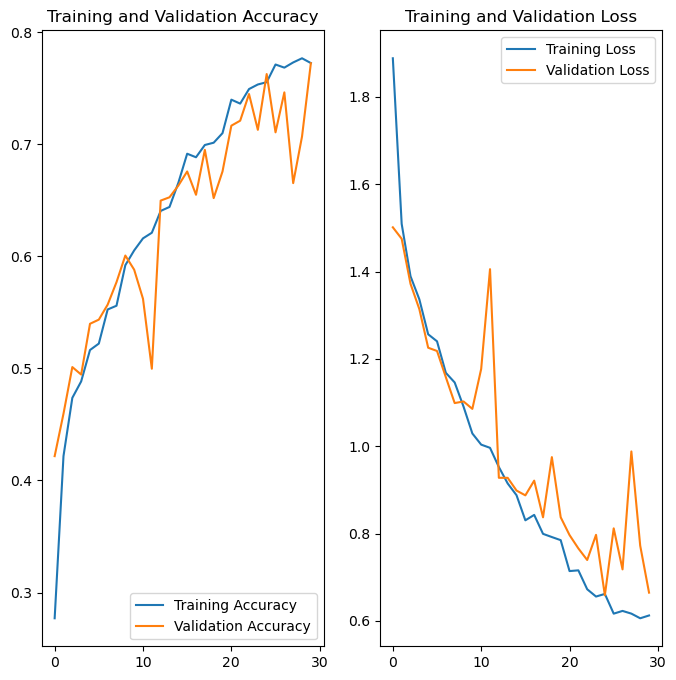

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We can infer that the Model is fit with a good enough accuracy for both Train and Validation Data of max accuracy around 75%
Rectifying the Class Imbalance and performing Data augumentation on the dataset has resulted in a model with higher accuracy and overcoming overfitting
This is a good model to be used to predict Skin Cancer using CNN

Analysis of the Project
1. Problem and Objectives

    The primary objective of this project is to develop a CNN model for accurate detection of melanoma, a severe and potentially fatal type of skin cancer.
    Early detection through automated systems has the potential to significantly reduce manual diagnostic efforts for dermatologists, improving patient outcomes.

2. Dataset and its Challenges

    Dataset Overview: The dataset contains 2,357 images spanning 9 categories of skin cancer types, including both benign and malignant cases.
    Challenges Identified:
        Class imbalance: Some cancer types might dominate others, leading to biased predictions.
        Limited data: Data augmentation is required to simulate more diverse training samples and avoid overfitting.

3. Technical Implementation

    Preprocessing:
        Data augmentation (e.g., rotation, flipping) is employed to enhance generalization and balance the dataset.
        Efficient data loading and visualization were achieved using TensorFlow utilities.
    Model Architecture:
        A custom CNN is designed with convolutional, pooling, normalization, and dense layers.
        The use of TensorFlow and Keras ensures flexibility in experimentation and scalability.
    Training and Evaluation:
        Achieved a maximum accuracy of ~75%, a strong baseline for melanoma detection.
        Overfitting was mitigated through regularization and data augmentation.

4. Strengths of the Project

    Practical Relevance: Targets a critical healthcare issue with significant societal impact.
    Comprehensive Workflow: Includes data preprocessing, augmentation, training, and evaluation steps.
    Flexibility: The modular architecture and choice of TensorFlow allow for easy scalability and upgrades.

5. Areas for Improvement

    Accuracy and Performance: The current accuracy (~75%) is promising but leaves room for improvement, particularly for clinical applications where higher precision is critical.
    Advanced Architectures: Experimenting with pre-trained models like ResNet, EfficientNet, or MobileNet could lead to better results.
    Dataset Diversity: Incorporating larger and more diverse datasets could improve the model's robustness and reduce bias.
    Metrics: Incorporating precision, recall, and F1-score metrics can provide a more detailed understanding of the model's performance, especially in imbalanced datasets.

6. Impact and Future Scope

    Impact: This project lays the foundation for an AI-driven diagnostic tool for melanoma detection, with the potential to support dermatologists and improve diagnostic accuracy.
    Future Scope:
        Deploy the model in real-world settings, such as mobile or web applications.
        Validate the model on unseen datasets to assess its generalizability.
        Collaborate with healthcare professionals to refine the system for clinical adoption.